In [1]:
import pandas as pd
from datetime import datetime

In [2]:
from statsmodels.tsa import seasonal


In [3]:
def clean_datetime(dtstr):
    fmt = "%m/%d/%y %H:%M"
    
    try:
        return datetime.strptime(dtstr.strip(),fmt)
    except Exception as e:
        print e
        pass
    
clean_datetime("06/19/16 10:15")

datetime.datetime(2016, 6, 19, 10, 15)

In [4]:
def clean_date(dtstr):
    
    try: 
        return clean_datetime(dtstr).date()
    except:
        pass
    
clean_date("06/19/16 10:15")

datetime.date(2016, 6, 19)

In [5]:
def get_data():
    frames = []
    for y in ["2016","2017","2018"]:
        df = pd.read_excel("data/Middlesex Hospital Opioid Data.xlsx",
                          sheet_name=y).dropna(how="any")
        df["year"] = y
        frames.append(df.copy())
        
        
    ret = pd.concat(frames).reset_index()
    
    #ret["ORIG_ORDER_DT_TM"] = ret["ORIG_ORDER_DT_TM"].apply(clean_datetime)
    ret["datetime"] = ret["ORIG_ORDER_DT_TM"].apply(clean_datetime)
    ret["date"] = ret["ORIG_ORDER_DT_TM"].apply(clean_date)

    return ret

df = get_data()
df.head()

,index,O_CATALOG_DISP,MME,ORIG_ORDER_DT_TM,year,datetime,date
0,0,acetaminophen-codeine,18.0,06/19/16 10:15,2016,2016-06-19 10:15:00,2016-06-19
1,1,acetaminophen-codeine,18.0,02/20/16 20:48,2016,2016-02-20 20:48:00,2016-02-20
2,2,acetaminophen-codeine,21.5,05/14/16 16:23,2016,2016-05-14 16:23:00,2016-05-14
3,3,acetaminophen-codeine,21.5,01/01/16 15:56,2016,2016-01-01 15:56:00,2016-01-01
4,4,acetaminophen-codeine,21.5,06/20/16 22:54,2016,2016-06-20 22:54:00,2016-06-20


In [6]:
df.dtypes

index                        int64
O_CATALOG_DISP              object
MME                        float64
ORIG_ORDER_DT_TM            object
year                        object
datetime            datetime64[ns]
date                        object
dtype: object

In [7]:
df[df["year"]=="2016"].sort_values(by="date").tail(1)

,index,O_CATALOG_DISP,MME,ORIG_ORDER_DT_TM,year,datetime,date
2325,2325,acetaminophen-hydrocodone,150.0,01/04/18 07:52,2016,2018-01-04 07:52:00,2018-01-04


In [8]:
df[df["datetime"].apply(lambda x: not isinstance(x, datetime))]

,index,O_CATALOG_DISP,MME,ORIG_ORDER_DT_TM,year,datetime,date


In [9]:
pd.to_datetime(df["datetime"]).describe()

count                   19490
unique                  19273
top       2017-05-29 13:25:00
freq                        3
first     2016-01-01 02:01:00
last      2018-05-09 23:46:00
Name: datetime, dtype: object

In [12]:
import numpy as np
df.groupby("year").agg({"date":np.size})

,date
year,
2016,9746
2017,7774
2018,1970


In [25]:
7774./9746.

0.7976605786989535

In [26]:
df[df["year"]=="2016"]["date"].describe()

count           9746
unique           368
top       2016-09-04
freq              51
Name: date, dtype: object

In [27]:
df[df["year"]=="2017"]["date"].describe()

count           7774
unique           366
top       2017-12-23
freq              42
Name: date, dtype: object

In [28]:
df[df["year"]=="2018"]["date"].describe()

count           1970
unique           129
top       2018-03-10
freq              35
Name: date, dtype: object

In [29]:
len(df[df["year"]=="2018"]["date"].unique())

129

In [30]:
df["ymo"] = df["date"].apply(lambda x: datetime.strftime(x, "%Y-%m"))

In [31]:
df[df["date"] < datetime(2018,3,1).date()]["ymo"].value_counts().sort_index().plot()

In [32]:
df.dtypes

index                        int64
O_CATALOG_DISP              object
MME                        float64
ORIG_ORDER_DT_TM            object
year                        object
datetime            datetime64[ns]
date                        object
ymo                         object
dtype: object

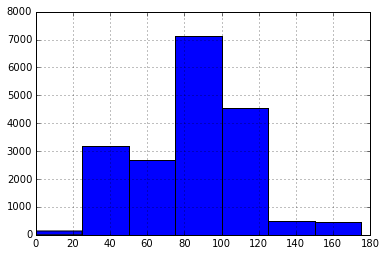

In [33]:
%matplotlib inline
df["MME"].hist(bins=[0,25,50,75,100,125,150,175])

In [34]:
df["MME"].describe()

count    19490.000000
mean        85.306285
std         56.086545
min          5.000000
25%         50.000000
50%         75.000000
75%        112.500000
max       2400.000000
Name: MME, dtype: float64

In [35]:
df["MME"].median()

75.0

In [36]:
df["MME"].mode()

0    75.0
dtype: float64

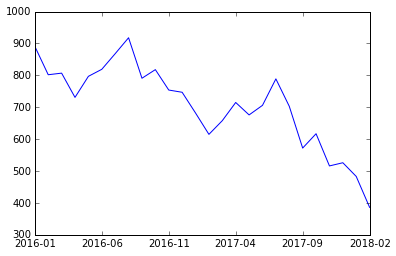

In [37]:
df[df["date"] < datetime(2018,3,1).date()]["ymo"].value_counts().sort_index().plot()

/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matr

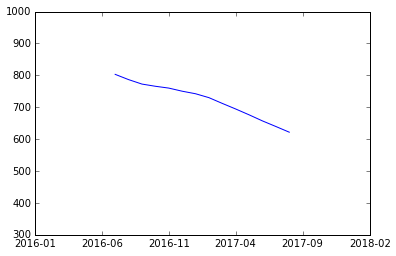

In [38]:
seasonal.seasonal_decompose(
    df["ymo"][df["date"] < datetime(2018,3,1).date()].value_counts().sort_index(),
    model='additive',
    freq=12
).trend.plot(ylim=(300,1000))

In [39]:
import matplotlib.pyplot as plt 

def trend_plot(df, col="ymo", freq=12, seas=False, mean=True, model='additive', min_p=1):
    
        
    df1 = df[df["date"] < datetime(2018,3,1).date()][col].value_counts().sort_index().to_frame()
    df2 =  seasonal.seasonal_decompose(
        df[col][df["date"] < datetime(2018,3,1).date()].value_counts().sort_index(),
        model=model,
        freq=freq).trend.to_frame()
    df3 = df["ymo"].value_counts().sort_index().rolling(12,
                                                        min_periods=min_p,
                                                        center=True).mean()
    
    ret = df1.copy()
    
    cols = ["Orders","Average"]
    if seas:
        ret = ret.join(df2, rsuffix="_trend")
        cols = ["Orders","Trend","Average"]
    
    if mean:
        ret = ret.join(df3, rsuffix="_mean")
        
    ret.columns = cols
        
    ax = ret.plot()
    
    #ret.columns = ["Orders","Average"]
    
    return ret
    
    

### Complete average + trend line

This version allows the rolling average line  ymo_mean to extend the full length of the chart, using fewer than 12 months of data for the first 6 (since it is a centered rolling average).

Note that the more complicated seasonal adjustment line (ymo_trend) looks pretty similar.

/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matr

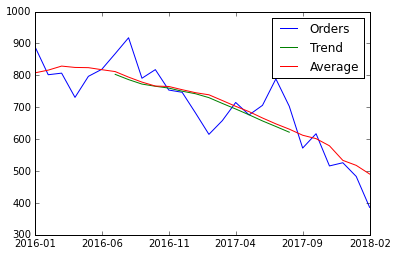

In [40]:

_ = trend_plot(df,seas=True, model="additive")


### Strict rolling average

This version requires 12 months of data to plot the average, so the first six months have no trend line


/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matr

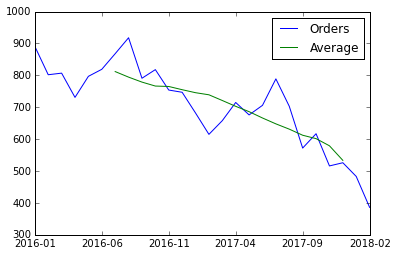

In [41]:
_ = trend_plot(df,seas=False, model="additive", min_p=12)

### The winnter: Permissive rolling average

This one is the most accessible because a rolling average is a simple concept. The fact that the line is complete is less likely to trip readers up. Even though it allows for less accurate trend values in the first 6 months, we will present this a rough approximation, and it will be presented along with the actual numbers. Overall it tells a true story in the sense that it's better to be approximately right than exactly wrong.

/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matr

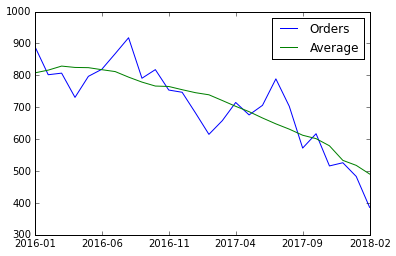

In [42]:

_ = trend_plot(df,model="multiplicative")

/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Library/Python/2.7/site-packages/numpy-override/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matr

	Orders	Average
2016-01	891	808
2016-02	802	816
2016-03	807	829
2016-04	731	825
2016-05	797	824
2016-06	819	818
2016-07	868	812
2016-08	918	794
2016-09	791	779
2016-10	818	766
2016-11	754	765
2016-12	747	755
2017-01	682	746
2017-02	615	739
2017-03	658	721
2017-04	715	703
2017-05	676	686
2017-06	706	666
2017-07	789	648
2017-08	703	631
2017-09	572	612
2017-10	617	602
2017-11	516	579
2017-12	526	533
2018-01	483	518
2018-02	386	491



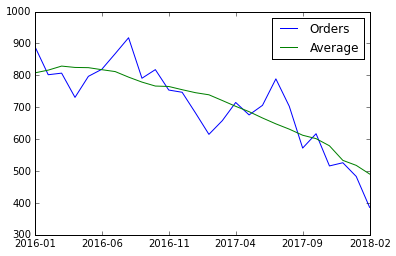

In [43]:
# Output for highchart

print trend_plot(df,model="multiplicative").to_csv(sep="\t",float_format="%.0f")

## Norwalk

In [44]:
nw = pd.read_csv("data/norwalk.tsv", sep="\t")
nw["TOTAL"] = pd.to_numeric(nw["TOTAL"].apply(lambda x: x.replace(",","")))
nw.head()

,DRUG TYPE,ymo,TOTAL,Unnamed: 3
0,Opiates,2016-1,1712,Initiation
1,Opiates,2016-2,1555,Change Champions
2,Opiates,2016-3,1706,NaN
3,Opiates,2016-4,1585,NaN
4,Opiates,2016-5,1568,NaN


In [401]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib.pyplot as plt
def plot_nw(df):
    
    df1 = df.set_index("ymo")["TOTAL"]
    df2 = df1.rolling(12,
                      min_periods=1,
                      center=True).mean()
    
    ret = df1.to_frame().join(df2.to_frame(),rsuffix="_mean")
    
    ret.columns = ["Orders","Average"]
    
    WIDTH=6
    HEIGHT=4
    ax = ret.plot(      
        #ylim=(0,ret["TOTAL"].max() * 1.1)
        grid=True,
        figsize=(WIDTH,HEIGHT),
        legend=False,
        label='Inline label'
    )
    
    # Add line labels
    nlines = len(ax.lines)
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    print xmin, xmax
    for l in range(nlines):
        # get xy data and scale it to the NxN squares
        line = ax.lines[l]
        xy = line.get_xydata()
        #print xy
        pos = xy[-1]
        
        
        x = pos[0]
        y = pos[1]
    
        ax.annotate(
            line.get_label(), 
            xy=(x, y),
            xytext=(x + .3,y),
            fontsize=14,
            family="sans-serif"
        )
        
        scalex = lambda x: x / (xmax)
        scaley = lambda y: 1 - y / (ymax)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
                
    #plt.close()

    return ret

0.0 23.0


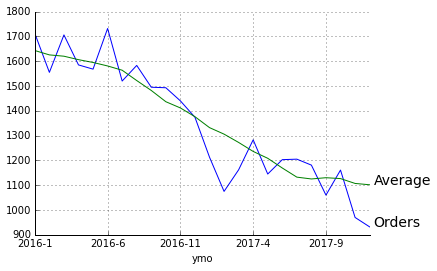

In [402]:
_ = plot_nw(nw)
plt.show()

0.0 23.0
ymo	Orders	Average
2016-1	1712	1643
2016-2	1555	1625
2016-3	1706	1620
2016-4	1585	1606
2016-5	1568	1595
2016-6	1732	1581
2016-7	1520	1564
2016-8	1583	1522
2016-9	1495	1482
2016-10	1493	1437
2016-11	1440	1412
2016-12	1374	1376
2017-1	1213	1332
2017-2	1075	1306
2017-3	1162	1272
2017-4	1283	1236
2017-5	1145	1208
2017-6	1203	1169
2017-7	1205	1132
2017-8	1181	1125
2017-9	1060	1130
2017-10	1161	1127
2017-11	970	1107
2017-12	932	1102



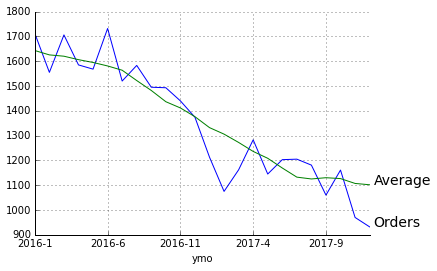

In [409]:
print plot_nw(nw).to_csv(sep="\t", float_format="%.0f")

In [48]:
1. - (13590. / 18763.)

0.2757021798219901